# IMO vs UoL

Take the concrec dat files from IMO and UoL

* 2 example days example_data/IMO/Datestamp exmaple_data/UoL/datestamp
* 1 produce B2R diff plots for each hour
* Stats of diff?

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d import axes3d
from matplotlib.font_manager import FontProperties
import os
import datetime as dt
import pytz
import utm
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
import cartopy
import cartopy.feature as cfeat
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import netCDF4
from dateutil.parser import parse

def Read_Two_Column_File(file_name):
    with open(file_name, 'r') as data:
        x = []
        y = []
        for line in data:
            p = line.split()
            x.append(float(p[0]))
            y.append(float(p[1]))

    return x, y

# Following gendata.py
date = '20181129/' # Most Recent run filled in here
imopath = 'example_data/IMO/'
uolpath = 'example_data/UoL/'
imoconcDir = imopath  + date
uolconcDir =  uolpath + date
ixyFile = imoconcDir + 'xy_masaya.dat'
lxyFile = uolconcDir + 'xy_masaya.dat'
outDir = "../plots/diffs"
nConcFiles = 48  # Number of conc files to process (48 = full 2 days)
towns = (' El Panama', ' Rigoberto', ' Pacaya', ' El Crucero',
         ' La Concepcion', ' Masaya', ' San Marcos',
         ' San Rafael del Sur', ' Diriamba', ' Jinotepe', ' Masatepe')
townCoords = ((-86.2058, 11.972), (-86.2021, 11.9617), (-86.3013, 11.9553),
              (-86.3113, 11.9923), (-86.189772, 11.936161),
              (-86.096053, 11.973523), (-86.20317, 11.906584),
              (-86.43639, 11.847034), (-86.239592, 11.85632),
              (-86.19993, 11.85017), (-86.143758, 11.91512))
cities = (' MANAGUA',)
cityCoords = ((-86.29, 12.12),)
volcCoords = (-86.1608, 11.9854)
so2title = 'Difference in UoL CALPUF vs IMO Calpuf'
font = FontProperties()
font.set_weight('bold')
font.set_family('monospace')

startDate = pytz.utc.localize(parse('20181129'))
dates = []
for i in range(nConcFiles):
    iDate = startDate + dt.timedelta(hours=i + 1)
    dates.append(iDate)


def concfiles(nConcFiles, concDir):
    filenames = []
    filePaths = []
    for i in range(nConcFiles):
        s = str('{:02}'.format(i + 1))  # Ensures e.g. '1' is converted to '01'
        fileName = 'concrec0100' + s + '.dat'
        filenames.append(fileName)
        filePath = os.path.join(concDir, fileName)
        filePaths.append(filePath)
        assert os.path.exists(filePath), "File " + \
            filePath + " not found. Check path."
    return filePaths 

imofp = concfiles(nConcFiles, imoconcDir)
uolfp = concfiles(nConcFiles, uolconcDir)

In [2]:
def genxy(xyFile):
    x, y = Read_Two_Column_File(xyFile)  # read in x,y data
    xunq, yunq = np.unique(x), np.unique(y)  # get unique x,y coordinates
    nx, ny = len(xunq), len(yunq)  # number of unique x,y coordinates
    # Use utm package to convert from x,y to lat,lon...
    # ...Nicaragua is UTM zone 16P, and we must convert to metres first:
    lat = [utm.to_latlon(x[i] * 1000, y[i] * 1000, 16, 'P')[0]
           for i in np.arange(0, len(x))]
    lon = [utm.to_latlon(x[i] * 1000, y[i] * 1000, 16, 'P')[1]
           for i in np.arange(0, len(x))]
    # Create gridded field of lat,lon of appropriate size:
    glat, glon = np.reshape(lat, (ny, nx)),  np.reshape(lon, (ny, nx))
    # Also grab range for static plots
    latMin = min(lat)
    latMax = max(lat)
    lonMin = min(lon)
    lonMax = max(lon)
    return glat, glon, latMin, latMax, lonMin, lonMax, ny, nx


In [3]:
def conc_array(ny, nx, filePaths, dates):
    #for fle, dat in zip(filePaths[0], dates[0]):
        # Read in concentration data:
    f = open(filePaths[30], 'r')
    lines = f.read().splitlines()
    f.close
    # Process concentration data into desired format:
    conc = np.array([float(X) for X in lines]) * 100**3  # ug/cm^3 -> ug/m^3
    concAry = np.reshape(conc, (ny, nx))  # Reshape data onto latlon grid
    return concAry

In [14]:
# Checked, as expected lat lons same between both
def plot_diff(ixyFile, imofp, uolfp, dates):
    glat, glon, latMin, latMax, lonMin, lonMax, ny, nx =  genxy(ixyFile)
    request = cimgt.OSM()
    fig = plt.subplots(nrows=1, ncols=1, figsize=(15, 15))
    ax1 = plt.subplot(1, 1, 1, projection=ccrs.PlateCarree())
    #ax1.coastlines('50m')
    #ax1.add_image(request, 10, interpolation='spline36')
    ax1.set_extent([lonMin,lonMax,latMin,latMax], ccrs.PlateCarree())
    imoconc = conc_array(ny, nx, imofp, dates)
    uolconc = conc_array(ny, nx, uolfp, dates)
    concdiff = uolconc - imoconc 
    perc = concdiff#/uolconc *100
    scale = perc 
    scale[abs(scale)<1]=np.nan
    binLims = np.arange(-210,210,10)+5
    p = ax1.contourf(glon, glat, scale, cmap=plt.cm.get_cmap('seismic'))
    #gl = ax1.gridlines(draw_labels=True, alpha=0.2)
    #gl.xlabels_top = gl.ylabels_right = False
    #gl.xformatter = LONGITUDE_FORMATTER
    #gl.yformatter = LATITUDE_FORMATTER
    cbar = plt.colorbar(p, extend='both', orientation='horizontal',ticks=np.arange(-200,205,40), label='% difference')
    cbar.ax.tick_params( labelsize=14) 
    return concdiff, uolconc, imoconc

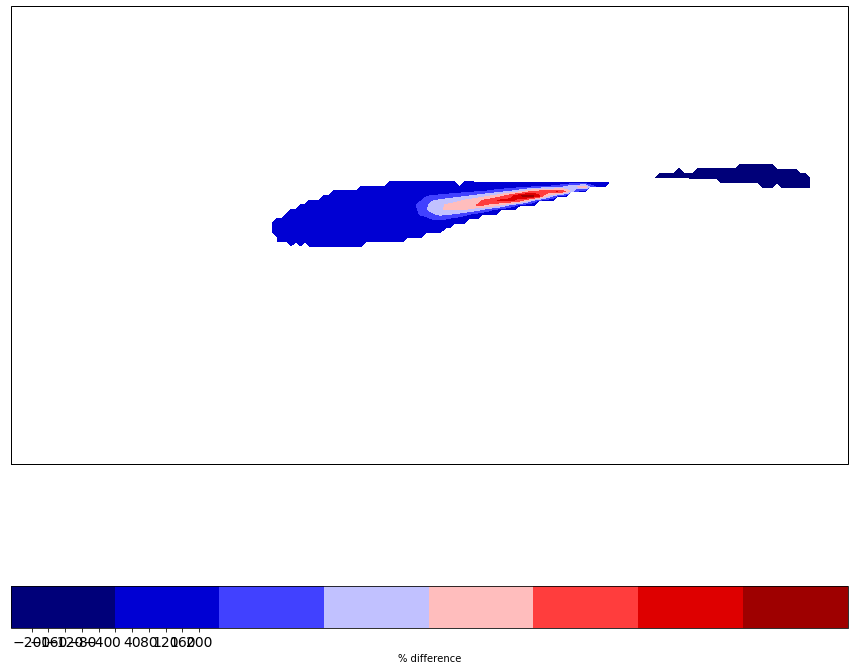

In [15]:
cdf = plot_diff(ixyFile, imofp, uolfp, dates)

In [16]:
cd ~/UNRESP_FORECAST/

/nfs/earcemac/projects/unresp/ForecastVisualized/UNRESPForecastingSystem


In [18]:
cd Python/


/nfs/earcemac/projects/unresp/ForecastVisualized/UNRESPForecastingSystem/Python


In [28]:
import maptoolkit as mtk

In [29]:
from dateutil.parser import parse

In [30]:
date = '20181129/' # Most Recent run filled in here

startDate = pytz.utc.localize(parse('20181129'))

mpt = mtk.Masaya_Maps()

In [38]:
mtk.Masaya_Maps.mro


<function Masaya_Maps.mro()>